# QAI Hub Model Compilation and Deployment Tutorial

## 🎯 Overview

This notebook demonstrates how to compile, profile, and run inference with machine learning models using **Qualcomm AI Hub (QAI Hub)** for deployment on **devices in the cloud**. We will work with two different types of computer vision models:

1. **YOLO-NAS** - Object detection (80 COCO classes: people, cars, animals, etc.)
2. **HagRID YOLO** - Hand gesture recognition (34 gesture classes: thumbs up, peace sign, etc.)

## 🚀 What You'll Learn

By the end of this notebook, you'll understand how to use the Qualcomm AI Hub to do the following:

- **Model Compilation**: Converting ONNX models to DLC format for Qualcomm chips
- **Performance Profiling**: Measuring model speed and efficiency on target hardware
- **Inference Testing**: Running predictions on real images
- **Result Visualization**: Creating annotated images with detected objects/gestures
- **Deployment Preparation**: Getting models ready for Android app integration



# Qualcomm AI Hub Setup Tutorial

This tutorial will guide you through setting up Qualcomm AI Hub in your Python environment.

## Prerequisites
Before running this notebook, make sure you have:
1. Created a conda environment with Python 3.8-3.10 (Qualcomm's recommendation)
2. Activated that environment
3. Launched Jupyter from the activated environment

### Terminal Commands (Run these BEFORE opening this notebook):
```bash
# Create conda environment.
conda create -n qaihub python=3.10

# Activate environment.
conda activate qaihub

# Install Jupyter (if needed).
conda install jupyter

# Launch Jupyter.
jupyter notebook


In [ ]:
# Install qai-hub package.
!pip install qai-hub

In [ ]:
# Import necessary libraries.
from typing import List, Dict

import os

import numpy as np
import qai_hub as hub

from PIL import Image, ImageDraw, ImageEnhance, ImageFont

print("✅ All libraries imported successfully!")
print(f"QAI Hub version: {hub.__version__}")

✅ All libraries imported successfully!
QAI Hub version: 0.30.0


## Get Your API Token and Configure

Before configuring, you need to get your API token:

1. **Sign into AI Hub**: Go to https://app.aihub.qualcomm.com/
2. **Navigate to Settings**: Click on "Your ID" → "Settings" → "API Token"  
3. **Copy your token**: You'll use this in the next step

⚠️ **Security Note**: Keep your API token private. Don't commit it to version control.

In [ ]:
!qai-hub configure --api_token YOUR_API_TOKEN


## To see available devices on QAI Hub

In [ ]:
!qai-hub list-devices 

## To see specifc device on QAI Hub

In [4]:
!qai-hub list-devices --device "QCS6490 (Proxy)"

+-----------------+------------+----------+------+------------------------+-------------------------------------------+
|      Device     |     OS     |  Vendor  | Type |        Chipset         |               CLI Invocation              |
+-----------------+------------+----------+------+------------------------+-------------------------------------------+
| QCS6490 (Proxy) | Android 12 | Qualcomm | Iot  | qualcomm-qcs6490-proxy | --device "QCS6490 (Proxy)" --device-os 12 |
+-----------------+------------+----------+------+------------------------+-------------------------------------------+


## Convert to NWHC format 

In [ ]:
!pip install onnx-graphsurgeon
!pip install scc4onnx 

In [ ]:
!scc4onnx -if ./assets/models/yolo_nas_s.onnx -of ./assets/models/yolo_nas_s_nhwc.onnx --input_op_names_and_order_dims input "[0,2,3,1]"

## Profile original onnx model 

In [ ]:
def profile_model(MODEL_PATH, TARGET_DEVICE):
    """
    Profile model performance on a specified device.
    """
    print(f"📊 Starting model profiling on {TARGET_DEVICE}...")

    profile_job = hub.submit_profile_job(
        model=MODEL_PATH,
        device=hub.Device(TARGET_DEVICE)
    )

    print(f"⏳ Profile job submitted: {profile_job.job_id}")
    profile_job.wait()

    status = profile_job.get_status()
    success = status.code == "SUCCESS" if hasattr(status, 'code') else str(status).upper() == "SUCCESS"

    if success:
        print("✅ Profiling completed successfully!")
        return profile_job
    else:
        print(f"❌ Profiling failed: {status}")
        return None

In [ ]:
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: /Users/shaahmed/Documents/chain/QAIHUB


In [ ]:
# Usage for YOLO-NAS S.
MODEL_PATH = "./assets/models/yolo_nas_s_nhwc.onnx"
TARGET_DEVICE = "QCS6490 (Proxy)"

# Profile the model.
profile_job = profile_model(MODEL_PATH, TARGET_DEVICE)

📊 Starting model profiling on QCS6490 (Proxy)...
Uploading yolo_nas_s_nhwc.onnx


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46.5M/46.5M [00:04<00:00, 10.7MB/s]


Scheduled profile job (jpv082zr5) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jpv082zr5/

⏳ Profile job submitted: jpv082zr5
Waiting for profile job (jpv082zr5) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          
✅ Profiling completed successfully!


## Compile ONNX to DLC 

### Prepare Calibration data for quantization. 

In [ ]:

def generate_calibration_data(image_path: str) -> Dict[str, List[np.ndarray]]:
    """
    Generate calibration data for quantization using image variations.
    Creates 4 different versions of the input image for robust quantization.
    """
    print("🔧 Creating calibration samples for quantization...")

    calibration_samples = []

    if not os.path.exists(image_path):
        print(f"❌ Calibration image not found: {image_path}")
        return {"input": []}

    # Load original image.
    original = Image.open(image_path)
    if original.mode != 'RGB':
        original = original.convert('RGB')

    def process_image(img, description):
        """Helper to process each calibration image consistently."""

        # Resize to target size.
        resized = img.resize((320, 320), Image.LANCZOS)

        # Convert to array and normalize [0, 1].
        array = np.array(resized, dtype=np.float32) / 255.0
        # Add batch dimension: (1, 320, 320, 3) - NHWC format.
        array = np.expand_dims(array, axis=0)
        print(f"   {description}: {array.shape}, range=[{array.min():.3f}, {array.max():.3f}]")
        return array


    # 1. Original image.
    calibration_samples.append(process_image(original, "Original"))

    # 2. Horizontally flipped (different spatial patterns).
    flipped = original.transpose(Image.FLIP_LEFT_RIGHT)
    calibration_samples.append(process_image(flipped, "Flipped"))

    # 3. Darker version (low-light conditions).
    enhancer = ImageEnhance.Brightness(original)
    darker = enhancer.enhance(0.7)
    calibration_samples.append(process_image(darker, "Darker"))

    # 4. Brighter version (high-light conditions).
    brighter = enhancer.enhance(1.3)
    calibration_samples.append(process_image(brighter, "Brighter"))

    calibration_data = {"input": calibration_samples}

    print(f"✅ Generated {len(calibration_samples)} calibration samples")
    print(f"   Each sample: {calibration_samples[0].shape} (NHWC format)")

    return calibration_data


# Generate calibration data.
print("📊 Preparing calibration data for quantization...")
IMAGE_PATH = "./assets/images/person.jpg"
calibration_data = generate_calibration_data(IMAGE_PATH)

📊 Preparing calibration data for quantization...
🔧 Creating calibration samples for quantization...
   Original: (1, 320, 320, 3), range=[0.000, 1.000]
   Flipped: (1, 320, 320, 3), range=[0.000, 1.000]
   Darker: (1, 320, 320, 3), range=[0.000, 0.741]
   Brighter: (1, 320, 320, 3), range=[0.000, 1.000]
✅ Generated 4 calibration samples
   Each sample: (1, 320, 320, 3) (NHWC format)


### Compile Job Code

In [ ]:
def compile_model_to_dlc(model_path: str, calibration_data: Dict):
    """
    Compile ONNX model to DLC format with quantization and Android app requirements.
    """
    print(f"🚀 Starting DLC compilation...")
    print(f"   Model: {model_path}")
    print(f"   Target: {TARGET_DEVICE}")  
    print(f"   Mode: Quantized with calibration")

    # Build compilation options for Android app compatibility.
    compile_options = [
        "--target_runtime qnn_dlc",                    # Qualcomm runtime
        "--quantize_full_type int8",                   # 8-bit quantization  
        "--quantize_io",                               # Quantize I/O
        "--output_names output_bboxes,output_classes"  # Custom output names
    ]

    options_str = " ".join(compile_options)

    # Input specification (NHWC format as required by app).
    input_specs = {"input": (1, 320, 320, 3)}

    print(f"\n📋 Compilation Configuration:")
    print(f"   Input specs: {input_specs}")
    print(f"   Options: {options_str}")
    print(f"   Calibration samples: {len(calibration_data['input'])}")

    compile_job = hub.submit_compile_job(
        model=model_path,
        device=hub.Device(TARGET_DEVICE),  
        input_specs=input_specs,
        options=options_str,
        calibration_data=calibration_data  
    )

    print(f"\n⏳ Compilation job submitted: {compile_job.job_id}")
    print("   Waiting for compilation to complete...")

    compile_job.wait()
    status = compile_job.get_status()

    status = compile_job.get_status()
    success = status.code == "SUCCESS" if hasattr(status, 'code') else str(status).upper() == "SUCCESS"

    if success:
        print("✅ DLC compilation completed successfully!")
        return compile_job
    else:
        print(f"❌ Compilation failed: {status}")
        return None

# Run compilation.
compile_job = compile_model_to_dlc(MODEL_PATH, calibration_data)

🚀 Starting DLC compilation...
   Model: ./assets/models/yolo_nas_s_nhwc.onnx
   Target: QCS6490 (Proxy)
   Mode: Quantized with calibration

📋 Compilation Configuration:
   Input specs: {'input': (1, 320, 320, 3)}
   Options: --target_runtime qnn_dlc --quantize_full_type int8 --quantize_io --output_names output_bboxes,output_classes
   Calibration samples: 4
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Uploading yolo_nas_s_nhwc.onnx


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46.5M/46.5M [00:02<00:00, 20.7MB/s]
Uploading dataset: 830kB [00:01, 559kB/s]                                                                                                                   <?, ?B/s]


Scheduled compile job (jgjz93ke5) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jgjz93ke5/


⏳ Compilation job submitted: jgjz93ke5
   Waiting for compilation to complete...
Waiting for compile job (jgjz93ke5) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          
✅ DLC compilation completed successfully!


## Profile Compiled Model to see difference

In [ ]:
def profile_compiled_model(compile_job):
    """Profile the compiled quantized model performance."""
    print(f"📊 Starting model profiling on {TARGET_DEVICE}...")

    target_model = compile_job.get_target_model()
    profile_job = hub.submit_profile_job(
        model=target_model,
        device=hub.Device(TARGET_DEVICE)
    )

    print(f"⏳ Profile job submitted: {profile_job.job_id}")
    profile_job.wait()

    status = profile_job.get_status()
    success = status.code == "SUCCESS" if hasattr(status, 'code') else str(status).upper() == "SUCCESS"

    if success:
        print("✅ Profiling completed successfully!")
    else:
        print(f"❌ Profiling failed: {status}")
        return None

# Run profiling.
profile_job = profile_compiled_model(compile_job)

📊 Starting model profiling on QCS6490 (Proxy)...
Scheduled profile job (jpeeq64vp) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jpeeq64vp/

⏳ Profile job submitted: jpeeq64vp
Waiting for profile job (jpeeq64vp) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          
✅ Profiling completed successfully!


## Run Inference and Visualize Results

🚀 Simple YOLO inference on: person.jpg
   Format: int8, NHWC
   Output: Top 10 detections only
📸 Image: 1920x1080 → 320x320
📐 Scale factors: x=6.00, y=3.38
🔄 Running inference...


Uploading dataset: 239kB [00:00, 905kB/s]                                                                                                                   <?, ?B/s]


Scheduled inference job (jgl6dw7mg) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jgl6dw7mg/

Waiting for inference job (jgl6dw7mg) completion. Type Ctrl+C to stop waiting at any time.
    ⏳ RUNNING_INFERENCE     ██░ 2/3 ...

    ✅ SUCCESS                          


tmprntv6s87.h5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 73.8k/73.8k [00:00<00:00, 518kB/s]


🔍 Raw outputs:
   Bboxes: (1, 2100, 4), dtype: float32
   Classes: (1, 2100, 80), dtype: float32
   After removing batch dim:
   Bboxes: (2100, 4)
   Classes: (2100, 80)
🔍 Bbox value analysis:
   Min bbox value: -60.9090
   Max bbox value: 341.7673
   Sample bbox values: [ 0.        0.       13.535338 42.29793 ]
   #1: Person (0.909) at [365,502,1360,1079]
   #2: Person (0.725) at [395,502,1360,1102]
   #3: Person (0.664) at [395,502,1350,1084]
   #4: Person (0.606) at [395,502,1350,1084]
   #5: Person (0.328) at [162,502,1360,1079]
   #6: Person (0.307) at [162,485,1360,1079]
   #7: Person (0.307) at [162,502,1390,1079]
   #8: Person (0.296) at [131,519,1390,1102]
   #9: Person (0.285) at [162,502,1360,1102]
   #10: Person (0.278) at [365,485,1492,1079]
💾 Results saved to: ./assets/images/person_top10.jpg


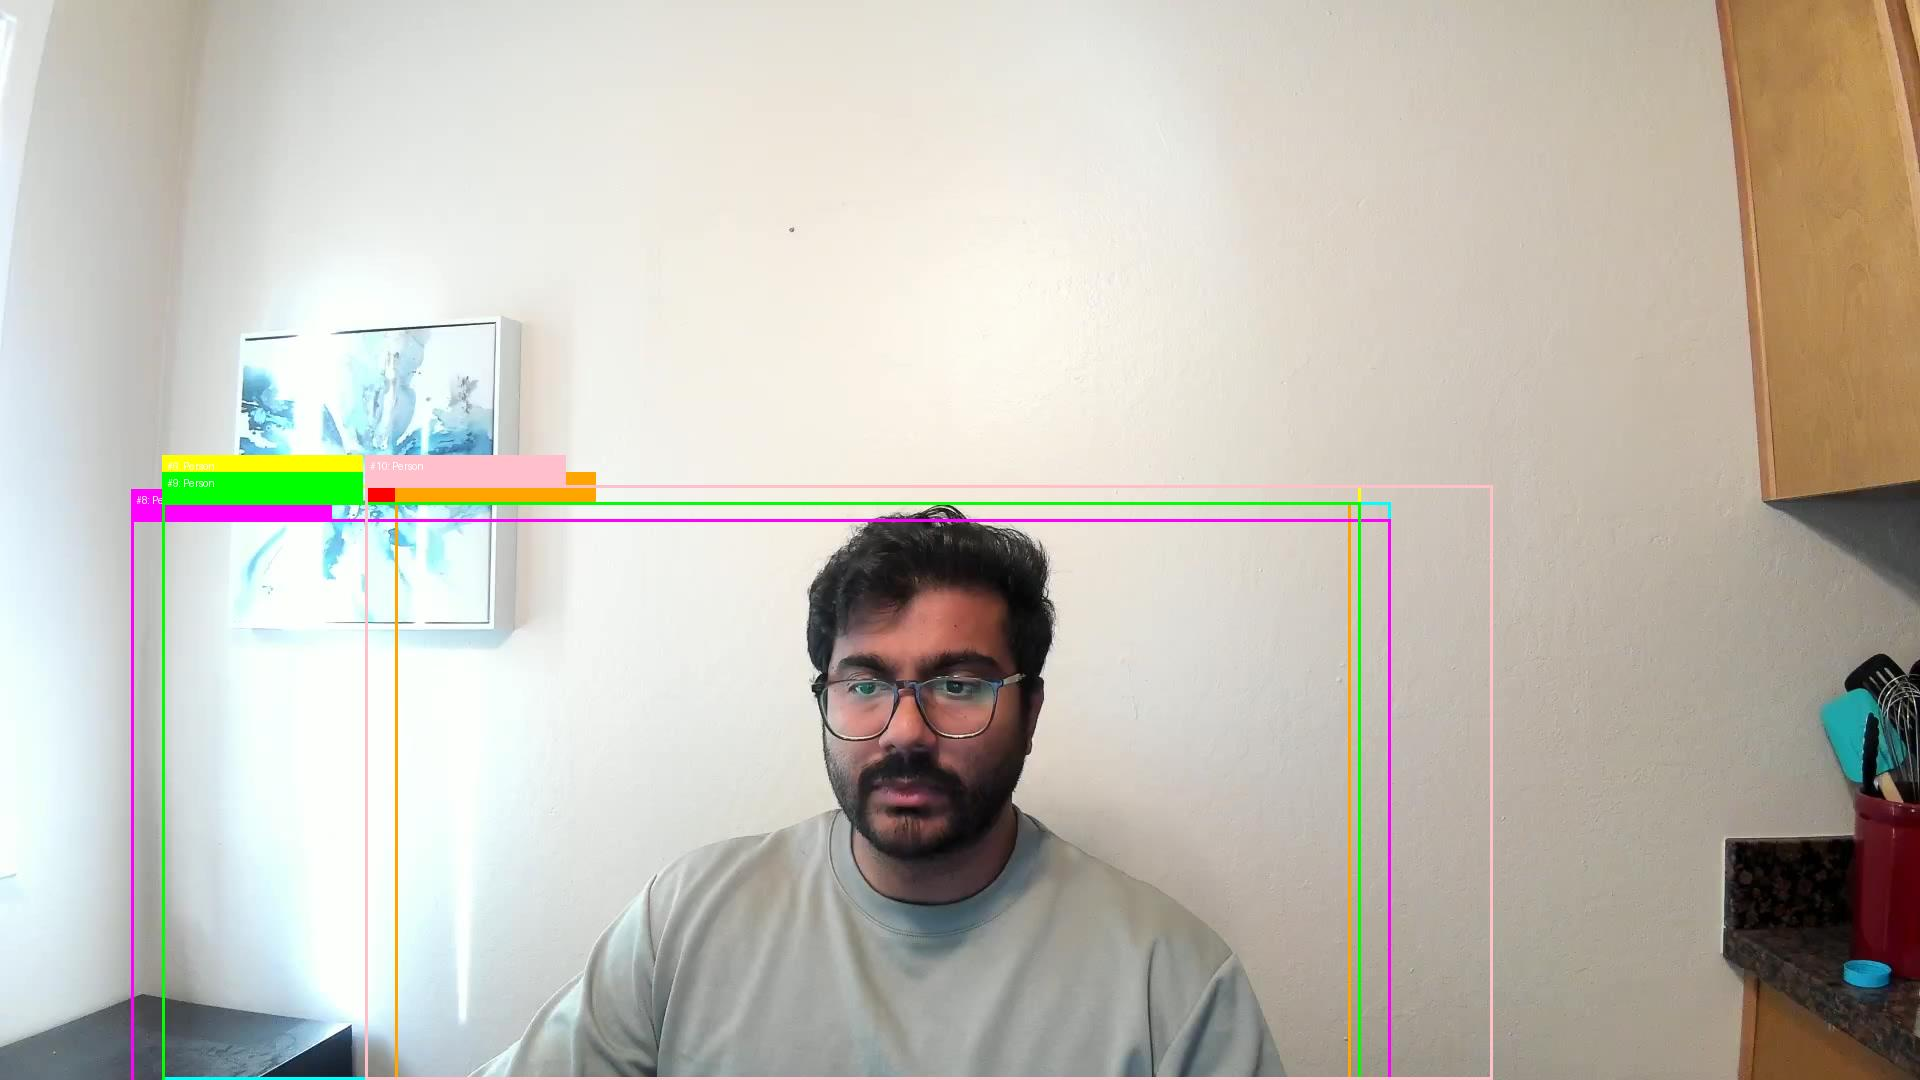


✅ Done! Top 10 detections:
   #1: Person (0.909)
   #2: Person (0.725)
   #3: Person (0.664)
   #4: Person (0.606)
   #5: Person (0.328)
   #6: Person (0.307)
   #7: Person (0.307)
   #8: Person (0.296)
   #9: Person (0.285)
   #10: Person (0.278)


In [ ]:
# COCO class names (80 classes).
COCO_CLASSES = [
    "Person", "Bicycle", "Car", "Motorcycle", "Airplane", "Bus", "Train", "Truck", "Boat",
    "Traffic Light", "Fire Hydrant", "Stop Sign", "Parking Meter", "Bench", "Bird", "Cat",
    "Dog", "Horse", "Sheep", "Cow", "Elephant", "Bear", "Zebra", "Giraffe", "Backpack",
    "Umbrella", "Handbag", "Tie", "Suitcase", "Frisbee", "Skis", "Snowboard", "Sports Ball",
    "Kite", "Baseball Bat", "Baseball Glove", "Skateboard", "Surfboard", "Tennis Racket",
    "Bottle", "Wine Glass", "Cup", "Fork", "Knife", "Spoon", "Bowl", "Banana", "Apple",
    "Sandwich", "Orange", "Broccoli", "Carrot", "Hot Dog", "Pizza", "Donut", "Cake",
    "Chair", "Couch", "Potted Plant", "Bed", "Dining Table", "Toilet", "TV", "Laptop",
    "Mouse", "Remote", "Keyboard", "Cell Phone", "Microwave", "Oven", "Toaster", "Sink",
    "Refrigerator", "Book", "Clock", "Vase", "Scissors", "Teddy Bear", "Hair Drier", 
    "Toothbrush"
]


def simple_preprocess(image_path: str) -> tuple:
    """Simple preprocessing - always NHWC format for int8 inference."""

    # Load image.
    original_image = Image.open(image_path).convert('RGB')
    orig_width, orig_height = original_image.size
    
    # Resize to 320x320 (same as calibration).
    resized_image = original_image.resize((320, 320), Image.LANCZOS)

    # Convert to array, normalize [0,1], add batch dimension.
    image_array = np.array(resized_image, dtype=np.float32) / 255.0
    image_array = np.expand_dims(image_array, axis=0)  # NHWC: (1, 320, 320, 3)

    # Calculate scale factors for bbox conversion.
    scale_x = orig_width / 320
    scale_y = orig_height / 320

    print(f"📸 Image: {orig_width}x{orig_height} → 320x320")
    print(f"📐 Scale factors: x={scale_x:.2f}, y={scale_y:.2f}")

    return image_array, original_image, scale_x, scale_y


def get_top10_detections(
        inference_results: dict, scale_x: float, scale_y: float):
    """Extract top 10 detections from model outputs - super simple!"""

    # Get the outputs and handle batch dimension properly
    bboxes_raw = inference_results['output_bboxes'][0]  # Shape: (1, 2100, 4)
    classes_raw = inference_results['output_classes'][0]  # Shape: (1, 2100, 80)

    print(f"🔍 Raw outputs:")
    print(f"   Bboxes: {bboxes_raw.shape}, dtype: {bboxes_raw.dtype}")
    print(f"   Classes: {classes_raw.shape}, dtype: {classes_raw.dtype}")

    # Remove batch dimension: (1, 2100, 4) → (2100, 4)
    bboxes = bboxes_raw[0]  # Now shape: (2100, 4)
    classes = classes_raw[0]  # Now shape: (2100, 80)

    print(f"   After removing batch dim:")
    print(f"   Bboxes: {bboxes.shape}")
    print(f"   Classes: {classes.shape}")

    # Dequantize if needed 
    # Even if dtype is float32, values might still be in quantized range
    if bboxes.max() > 1.0:  # Values appear to be in quantized range
        print(f"   Values appear quantized, applying dequantization")
        # Apply the same logic as original: scale = 1.0 / 255.0 for bbox outputs
        bboxes = bboxes * (1.0 / 255.0)

    if classes.max() > 1.0:  # Values appear to be in quantized range  
        classes = classes * (1.0 / 255.0)


def get_top10_detections(
        inference_results: dict, scale_x: float, scale_y: float):
    """Extract top 10 detections from model outputs - super simple!"""

    # Get the outputs and handle batch dimension properly.
    bboxes_raw = inference_results['output_bboxes'][0]  # Shape: (1, 2100, 4)
    classes_raw = inference_results['output_classes'][0]  # Shape: (1, 2100, 80)

    print(f"🔍 Raw outputs:")
    print(f"   Bboxes: {bboxes_raw.shape}, dtype: {bboxes_raw.dtype}")
    print(f"   Classes: {classes_raw.shape}, dtype: {classes_raw.dtype}")

    # Remove batch dimension: (1, 2100, 4) → (2100, 4)
    bboxes = bboxes_raw[0]  # Now shape: (2100, 4)
    classes = classes_raw[0]  # Now shape: (2100, 80)

    print(f"   After removing batch dim:")
    print(f"   Bboxes: {bboxes.shape}")
    print(f"   Classes: {classes.shape}")

    # Debug: Check the actual range of bbox values
    print(f"🔍 Bbox value analysis:")
    print(f"   Min bbox value: {bboxes.min():.4f}")
    print(f"   Max bbox value: {bboxes.max():.4f}")
    print(f"   Sample bbox values: {bboxes[0]}")

    # Dequantize int8 to float (simple: divide by 255)
    if bboxes.dtype == np.uint8:
        bboxes = bboxes.astype(np.float32) / 255.0
    if classes.dtype == np.uint8:
        classes = classes.astype(np.float32) / 255.0

    # Get confidence for each detection (max class probability)
    confidences = np.max(classes, axis=1)
    best_classes = np.argmax(classes, axis=1)

    # Get top 10 by confidence
    top10_indices = np.argsort(confidences)[-10:][::-1]  # Top 10, highest first

    detections = []
    for i, idx in enumerate(top10_indices):
        conf = confidences[idx]
        class_id = best_classes[idx]

        # Get bbox coordinates - use the same approach as original code
        x1, y1, x2, y2 = bboxes[idx]

        # Convert to integer coordinates and scale to original image (same as original)
        x1 = max(0, int(x1 * scale_x))
        y1 = max(0, int(y1 * scale_y))
        x2 = max(x1 + 1, int(x2 * scale_x))
        y2 = max(y1 + 1, int(y2 * scale_y))

        detection = {
            'rank': i + 1,
            'bbox': [x1, y1, x2, y2],
            'confidence': float(conf),
            'class_id': int(class_id),
            'class_name': COCO_CLASSES[class_id] if class_id < len(COCO_CLASSES) else f'Unknown_{class_id}'
        }
        detections.append(detection)

        print(f"   #{i+1}: {detection['class_name']} ({conf:.3f}) at [{x1},{y1},{x2},{y2}]")

    return detections


def draw_top10_results(
        original_image: Image.Image, detections: list, output_path: str,
        show_inline: bool = True
):
    """Draw top 10 detections with simple numbered labels."""

    # Simple colors (just cycle through these 10).
    colors = ['red', 'blue', 'green', 'orange', 'purple', 
              'yellow', 'cyan', 'magenta', 'lime', 'pink']

    # Draw on copy.
    result_image = original_image.copy()
    draw = ImageDraw.Draw(result_image)

    # Try to get a decent font.
    try:
        font = ImageFont.truetype("arial.ttf", 24)
    except:
        font = ImageFont.load_default()

    for det in detections:
        rank = det['rank']
        x1, y1, x2, y2 = det['bbox']
        color = colors[(rank-1) % len(colors)]

        # Draw bounding box.
        draw.rectangle([x1, y1, x2, y2], outline=color, width=3)

        # Simple label: just rank and class.
        label = f"#{rank}: {det['class_name']}"

        # Draw label background.
        draw.rectangle([x1, y1-30, x1+200, y1], fill=color)
        draw.text((x1+5, y1-25), label, fill='white', font=font)

    # Save result.
    result_image.save(output_path)
    print(f"💾 Results saved to: {output_path}")

    # Display inline in Jupyter notebook.
    if show_inline:
        try:
            # Method 1: Using IPython.display
            from IPython.display import Image as IPImage, display
            display(IPImage(output_path))
        except ImportError:
            try:
                # Method 2: Using matplotlib
                import matplotlib.pyplot as plt
                plt.figure(figsize=(12, 8))
                plt.imshow(result_image)
                plt.axis('off')
                plt.title('Top 10 Detections')
                plt.show()
            except ImportError:
                print("📱 Install IPython or matplotlib to see inline visualization")
                print(f"   For now, check the saved image: {output_path}")

    return output_path


def simple_inference_pipeline(
        image_path: str, compile_job, show_inline: bool = True):
    """Complete simple pipeline: preprocess → inference → top 10 → visualize"""

    print(f"🚀 Simple YOLO inference on: {os.path.basename(image_path)}")
    print(f"   Format: int8, NHWC")
    print(f"   Output: Top 10 detections only")

    # 1. Preprocess image
    input_data, original_image, scale_x, scale_y = simple_preprocess(image_path)

    # 2. Run inference
    print("🔄 Running inference...")
    target_model = compile_job.get_target_model()

    inference_job = hub.submit_inference_job(
        model=target_model,
        device=hub.Device(TARGET_DEVICE),
        inputs={"input": [input_data]}
    )

    inference_job.wait()
    results = inference_job.download_output_data()

    # 3. Get top 10 detections
    detections = get_top10_detections(results, scale_x, scale_y)

    # 4. Visualize (inline + save)
    output_path = image_path.replace('.jpg', '_top10.jpg')
    draw_top10_results(original_image, detections, output_path, show_inline=show_inline)

    # 5. Summary
    print(f"\n✅ Done! Top 10 detections:")
    for det in detections:
        print(f"   #{det['rank']}: {det['class_name']} ({det['confidence']:.3f})")

    return detections, output_path


detections, result_path = simple_inference_pipeline(IMAGE_PATH, compile_job)

## Download the compiled model

In [19]:
# Download and save to your specified path
target_model = compile_job.get_target_model()
model_path = 'assets/models/yolo_nas_s_int8.dlc'
target_model.download(model_path)

print(f"✅ Model downloaded and saved to: {model_path}")

yolo_nas_s_int8.dlc: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 11.9M/11.9M [00:00<00:00, 12.8MB/s]

Downloaded model to assets/models/yolo_nas_s_int8.dlc
✅ Model downloaded and saved to: assets/models/yolo_nas_s_int8.dlc


# Run all the same steps for YOLO-HAGRID model 

## Convert to NWHC format 

In [ ]:
!scc4onnx -if ./assets/models/yolo_nas_s.onnx -of ./assets/models/yolo_nas_s_nhwc.onnx --input_op_names_and_order_dims input "[0,2,3,1]"

## Profile Original onnx model

In [20]:
# Usage for your yolo_nas:
MODEL_PATH = "./assets/models/yolo_hagRID_nhwc.onnx"
TARGET_DEVICE = "QCS6490 (Proxy)"

# Profile the model
profile_job = profile_model(MODEL_PATH, TARGET_DEVICE)

📊 Starting model profiling on QCS6490 (Proxy)...
Uploading yolo_hagRID_nhwc.onnx


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10.1M/10.1M [00:00<00:00, 20.8MB/s]


Scheduled profile job (jp3vdo8ng) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jp3vdo8ng/

⏳ Profile job submitted: jp3vdo8ng
Waiting for profile job (jp3vdo8ng) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          
✅ Profiling completed successfully!


## Calibration data for HAGRID

In [ ]:
def generate_hagrid_calibration_data(
        image_path: str) -> Dict[str, List[np.ndarray]]:
    """
    Generate calibration data for HagRID model quantization.
    Creates 4 different versions of the input image for robust quantization.
    
    Key differences from YOLO:
    - Input size: 640x640 (instead of 320x320)
    - Still NHWC format: (1, 640, 640, 3)
    """
    print("🔧 Creating HagRID calibration samples for quantization...")
    print("   Target size: 640x640 (HagRID requirement)")
    
    calibration_samples = []
    
    if not os.path.exists(image_path):
        print(f"❌ Calibration image not found: {image_path}")
        return {"input": []}
    
    # Load original image
    original = Image.open(image_path)
    if original.mode != 'RGB':
        original = original.convert('RGB')
    
    def process_hagrid_image(img, description):
        """Helper to process each calibration image for HagRID (640x640)."""
        # Resize to HagRID target size: 640x640
        resized = img.resize((640, 640), Image.LANCZOS)
        # Convert to array and normalize [0,1]
        array = np.array(resized, dtype=np.float32) / 255.0
        # Add batch dimension: (1, 640, 640, 3) - NHWC format
        array = np.expand_dims(array, axis=0)
        print(f"   {description}: {array.shape}, range=[{array.min():.3f}, {array.max():.3f}]")
        return array
    
    # 1. Original image
    calibration_samples.append(process_hagrid_image(original, "Original"))
    
    # 2. Horizontally flipped (different hand orientations)
    flipped = original.transpose(Image.FLIP_LEFT_RIGHT)
    calibration_samples.append(process_hagrid_image(flipped, "Flipped"))
    
    # 3. Darker version (low-light hand detection)
    enhancer = ImageEnhance.Brightness(original)
    darker = enhancer.enhance(0.7)
    calibration_samples.append(process_hagrid_image(darker, "Darker"))
    
    # 4. Brighter version (high-light hand detection)
    brighter = enhancer.enhance(1.3)
    calibration_samples.append(process_hagrid_image(brighter, "Brighter"))
    
    calibration_data = {"input": calibration_samples}
    
    print(f"✅ Generated {len(calibration_samples)} HagRID calibration samples")
    print(f"   Each sample: {calibration_samples[0].shape} (NHWC format, 640x640)")
    
    return calibration_data


# Usage for HagRID model
print("📊 Preparing HagRID calibration data for quantization...")
IMAGE_PATH = "./assets/images/hand.jpg"
calibration_data = generate_hagrid_calibration_data(IMAGE_PATH)

📊 Preparing HagRID calibration data for quantization...
🔧 Creating HagRID calibration samples for quantization...
   Target size: 640x640 (HagRID requirement)
   Original: (1, 640, 640, 3), range=[0.000, 1.000]
   Flipped: (1, 640, 640, 3), range=[0.000, 1.000]
   Darker: (1, 640, 640, 3), range=[0.000, 0.729]
   Brighter: (1, 640, 640, 3), range=[0.000, 1.000]
✅ Generated 4 HagRID calibration samples
   Each sample: (1, 640, 640, 3) (NHWC format, 640x640)


## Compile with HagRID calibration data

In [ ]:
def compile_hagrid_model_to_dlc(model_path: str, calibration_data: Dict):
    """
    Compile HagRID ONNX model to DLC format with quantization and Android app requirements.
    
    Key differences from YOLO:
    - Input size: 640x640 (instead of 320x320)
    - Output: 8400 detections with 34 gesture classes
    """
    print(f"🚀 Starting HagRID DLC compilation...")
    print(f"   Model: {model_path}")
    print(f"   Target: QCS6490 (Proxy)")  
    print(f"   Mode: Quantized with calibration")
    print(f"   Input size: 640x640 (HagRID requirement)")
    
    # Build compilation options for Android app compatibility
    compile_options = [
        "--target_runtime qnn_dlc",                           # Qualcomm runtime
        "--quantize_full_type int8",                         # 8-bit quantization  
        "--quantize_io",                                      # Quantize inputs/outputs
        "--output_names output_bboxes,output_classes"        # Custom output names
    ]
    
    options_str = " ".join(compile_options)
    
    # Input specification for HagRID (NHWC format, 640x640)
    input_specs = {"input": (1, 640, 640, 3)}
    
    
    compile_job = hub.submit_compile_job(
        model=model_path,
        device=hub.Device("QCS6490 (Proxy)"),  
        input_specs=input_specs,
        options=options_str,
        calibration_data=calibration_data  
    )
        
    print(f"\n⏳ HagRID compilation job submitted: {compile_job.job_id}")
    print("   Waiting for compilation to complete...")
        
    compile_job.wait()
    status = compile_job.get_status()
        
    success = status.code == "SUCCESS" if hasattr(status, 'code') else str(status).upper() == "SUCCESS"
    
    if success:
        print("✅ HagRID DLC compilation completed successfully!")
        print("   Model ready for hand gesture detection")
        return compile_job
    else:
        print(f"❌ HagRID compilation failed: {status}")
        return None


# Set up paths for HagRID
MODEL_PATH = "./assets/models/yolo_hagRID_nhwc.onnx"

# Run HagRID compilation
print("\n🚀 Compiling HagRID model...")
compile_job = compile_hagrid_model_to_dlc(MODEL_PATH, calibration_data)


🚀 Compiling HagRID model...
🚀 Starting HagRID DLC compilation...
   Model: ./assets/models/yolo_hagRID_nhwc.onnx
   Target: QCS6490 (Proxy)
   Mode: Quantized with calibration
   Input size: 640x640 (HagRID requirement)
Uploading yolo_hagRID_nhwc.onnx



  0%|                                                                                                                           | 0.00/10.1M [00:00<?, ?B/s]
  9%|██████████▍                                                                                                        | 944k/10.1M [00:00<00:01, 9.47MB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10.1M/10.1M [00:00<00:00, 21.0MB/s]

Uploading dataset:   0%|                                                                                                        | 0.00/4.37M [00:00<?, ?B/s]
Uploading dataset: 4.37MB [00:01, 3.98MB/s]                                                                                                                 22.8MB/s]


Scheduled compile job (jgokxdmkp) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jgokxdmkp/


⏳ HagRID compilation job submitted: jgokxdmkp
   Waiting for compilation to complete...
Waiting for compile job (jgokxdmkp) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          
✅ HagRID DLC compilation completed successfully!
   Model ready for hand gesture detection


## Profile The new DLC HAGRID model

In [25]:
profile_job = profile_compiled_model(compile_job)

📊 Starting model profiling on QCS6490 (Proxy)...
Scheduled profile job (jpv0824r5) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jpv0824r5/

⏳ Profile job submitted: jpv0824r5
Waiting for profile job (jpv0824r5) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          
✅ Profiling completed successfully!


## Run Inferenece and Visualize Results

🚀 Fixed HagRID inference on: hand.jpg
   Format: int8 quantized, NHWC
   Input size: 640x640 with aspect ratio preservation
   Classes: 34 HagRID gestures
📸 Original: 1280x720
📐 Scale: 0.500, New size: 640x360
📦 Padding: x=0, y=140
🔄 Running HagRID inference...



Uploading dataset:   0%|                                                                                                         | 0.00/692k [00:00<?, ?B/s]
Uploading dataset: 696kB [00:00, 2.03MB/s]                                                                                                                  5.00MB/s]


Scheduled inference job (jpyrl8nl5) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jpyrl8nl5/

Waiting for inference job (jpyrl8nl5) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          



tmpfzt6963r.h5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 50.6k/50.6k [00:00<00:00, 6.02MB/s]

🔍 QAI Hub outputs:
   Bboxes: (8400, 4), dtype: float32
   Classes: (8400, 34), dtype: float32
Raw bbox sample: [25.067554 17.547287 50.13511  35.094574]
Bbox value ranges:
  X: 5.014 - 636.716
  Y: 10.027 - 634.209
  W: 5.014 - 478.790
  H: 5.014 - 368.493
Max probability range: 0.000 - 0.698
Valid detections (conf > 0.25): 12
Best detection raw bbox: [518.8984  310.83768 230.62149 250.67554]
Best detection score: 0.698
Best detection class: palm
Coordinates appear to be in pixel space
In 640x640 space - x1:403.6, y1:185.5, x2:634.2, y2:436.2
Converted bbox: [ 807.1753    90.99982 1268.4182   592.3509 ]
   #1: palm (0.698) at [817,101,1258,582]
   #2: palm (0.698) at [827,90,1280,592]
   #3: palm (0.698) at [817,101,1258,582]
   #4: palm (0.698) at [817,101,1258,582]
   #5: palm (0.698) at [827,101,1280,582]
   #6: palm (0.698) at [827,101,1280,582]
   #7: palm (0.698) at [817,80,1258,562]
   #8: palm (0.698) at [817,90,1258,592]
   #9: palm (0.698) at [817,90,1258,592]
   #10: palm (

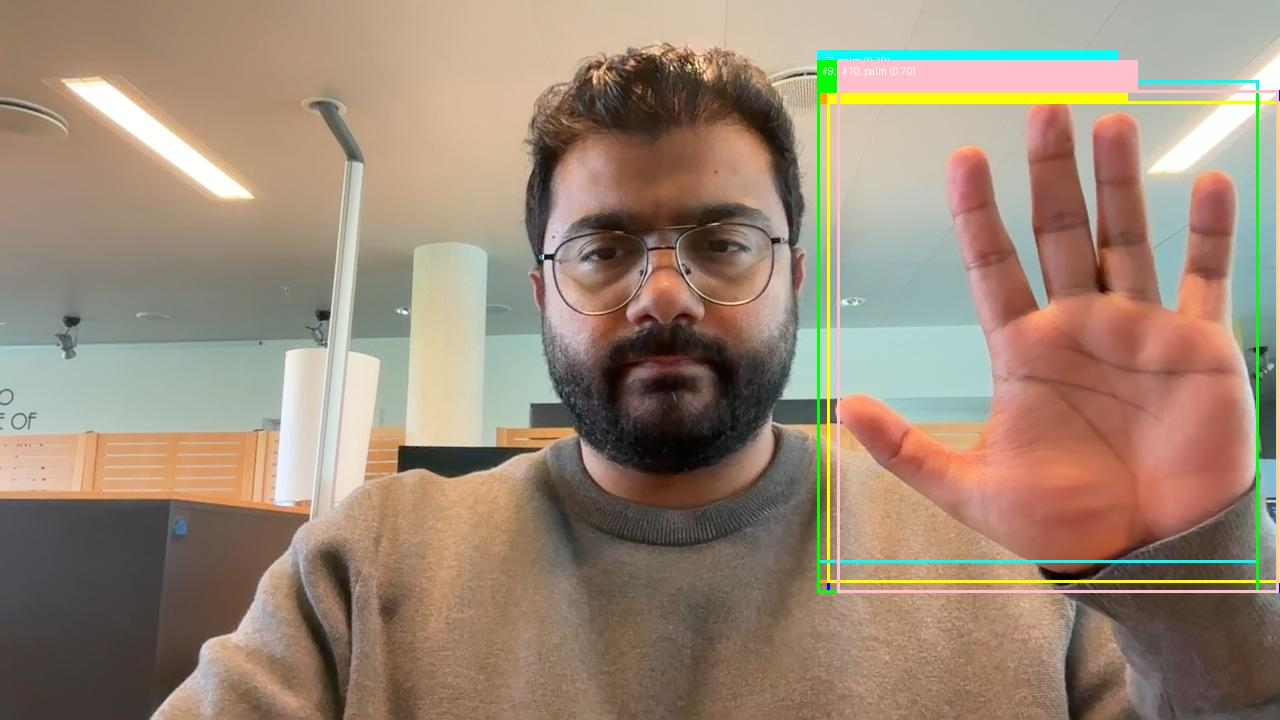


✅ Done! Top 10 gesture detections:
   #1: palm (0.698)
      Bbox: (817, 101, 1258, 582) Size: 441x481
   #2: palm (0.698)
      Bbox: (827, 90, 1280, 592) Size: 453x502
   #3: palm (0.698)
      Bbox: (817, 101, 1258, 582) Size: 441x481
   #4: palm (0.698)
      Bbox: (817, 101, 1258, 582) Size: 441x481
   #5: palm (0.698)
      Bbox: (827, 101, 1280, 582) Size: 453x481
   #6: palm (0.698)
      Bbox: (827, 101, 1280, 582) Size: 453x481
   #7: palm (0.698)
      Bbox: (817, 80, 1258, 562) Size: 441x482
   #8: palm (0.698)
      Bbox: (817, 90, 1258, 592) Size: 441x502
   #9: palm (0.698)
      Bbox: (817, 90, 1258, 592) Size: 441x502
   #10: palm (0.698)
      Bbox: (837, 90, 1278, 592) Size: 441x502


In [ ]:
# HagRIDv2 Dataset Classes - CORRECT ORDER (same as your working code)
HAGRID_V2_CLASSES = [
    'call',           # 0
    'dislike',        # 1
    'fist',           # 2
    'four',           # 3
    'grabbing',       # 4
    'grip',           # 5
    'hand_heart',     # 6
    'hand_heart2',    # 7
    'holy',           # 8
    'like',           # 9
    'little_finger',  # 10
    'middle_finger',  # 11
    'mute',           # 12
    'xsign',          # 13
    'ok',             # 14
    'one',            # 15
    'palm',           # 16
    'peace',          # 17
    'peace_inverted', # 18
    'point',          # 19
    'rock',           # 20
    'stop',           # 21
    'stop_inverted',  # 22
    'take_picture',   # 23
    'three',          # 24
    'three2',         # 25
    'three3',         # 26
    'three_gun',      # 27
    'thumb_index',    # 28
    'thumb_index2',   # 29
    'timeout',        # 30
    'two_up',         # 31
    'two_up_inverted',# 32
    'no_gesture'      # 33
]


def hagrid_preprocess_with_padding(image_path: str) -> tuple:
    """
    Preprocess image exactly like working ONNX code:
    - Aspect ratio preserving resize
    - Gray padding to 640x640
    - Track scale and padding for coordinate conversion
    """

    # Load image.
    image_pil = Image.open(image_path).convert('RGB')
    original_w, original_h = image_pil.size
    
    input_size = 640
    
    # Calculate scale to maintain aspect ratio (same as working code)
    scale = min(input_size / original_w, input_size / original_h)
    new_w = int(original_w * scale)
    new_h = int(original_h * scale)
    
    print(f"📸 Original: {original_w}x{original_h}")
    print(f"📐 Scale: {scale:.3f}, New size: {new_w}x{new_h}")
    
    # Resize image maintaining aspect ratio
    resized = image_pil.resize((new_w, new_h), Image.LANCZOS)
    
    # Create padded image with gray background (114 like working code)
    padded = Image.new('RGB', (input_size, input_size), color=(114, 114, 114))
    
    # Calculate padding offsets (center the image)
    pad_x = (input_size - new_w) // 2
    pad_y = (input_size - new_h) // 2
    
    print(f"📦 Padding: x={pad_x}, y={pad_y}")
    
    # Place resized image in center
    padded.paste(resized, (pad_x, pad_y))
    
    # Convert to numpy and normalize [0,1]
    image_array = np.array(padded, dtype=np.float32) / 255.0
    
    # Add batch dimension: NHWC format (1, 640, 640, 3)
    image_array = np.expand_dims(image_array, axis=0)
    
    # Store preprocessing info for coordinate conversion
    preprocess_info = {
        'scale': scale,
        'pad_x': pad_x,
        'pad_y': pad_y,
        'original_w': original_w,
        'original_h': original_h,
        'resized_w': new_w,
        'resized_h': new_h
    }
    
    return image_array, image_pil, preprocess_info


def get_top10_hagrid_gestures_fixed(
        inference_results: dict, preprocess_info: dict,
        conf_threshold: float = 0.25
):
    """
    Extract gesture detections using same logic as working ONNX code.
    Handles QAI Hub int8 quantization properly.
    """
    
    # Get outputs and remove batch dimension
    bboxes_raw = inference_results['output_bboxes'][0][0]  # (8400, 4)
    classes_raw = inference_results['output_classes'][0][0]  # (8400, 34)
    
    print(f"🔍 QAI Hub outputs:")
    print(f"   Bboxes: {bboxes_raw.shape}, dtype: {bboxes_raw.dtype}")
    print(f"   Classes: {classes_raw.shape}, dtype: {classes_raw.dtype}")
    
    # Dequantize int8 outputs (QAI Hub specific)
    if bboxes_raw.dtype == np.uint8:
        # For bbox outputs: assume quantized range maps to [0,1] like ONNX
        bboxes = bboxes_raw.astype(np.float32) / 255.0
        print(f"   Dequantized bboxes: range=[{bboxes.min():.4f}, {bboxes.max():.4f}]")
    else:
        bboxes = bboxes_raw.astype(np.float32)
    
    if classes_raw.dtype == np.uint8:
        # For class outputs: assume quantized range maps to [0,1] like ONNX  
        classes = classes_raw.astype(np.float32) / 255.0
        print(f"   Dequantized classes: range=[{classes.min():.4f}, {classes.max():.4f}]")
    else:
        classes = classes_raw.astype(np.float32)
    
    # Debug raw values (same as working code)
    print(f"Raw bbox sample: {bboxes[0]}")
    print(f"Bbox value ranges:")
    print(f"  X: {bboxes[:, 0].min():.3f} - {bboxes[:, 0].max():.3f}")
    print(f"  Y: {bboxes[:, 1].min():.3f} - {bboxes[:, 1].max():.3f}")
    print(f"  W: {bboxes[:, 2].min():.3f} - {bboxes[:, 2].max():.3f}")
    print(f"  H: {bboxes[:, 3].min():.3f} - {bboxes[:, 3].max():.3f}")
    
    # Get best class for each detection (same as working code)
    max_probs = np.max(classes, axis=1)
    class_ids = np.argmax(classes, axis=1)
    
    print(f"Max probability range: {max_probs.min():.3f} - {max_probs.max():.3f}")
    
    # Filter by confidence
    valid_mask = max_probs > conf_threshold
    valid_count = np.sum(valid_mask)
    print(f"Valid detections (conf > {conf_threshold}): {valid_count}")
    
    if valid_count == 0:
        print("⚠️ No detections above threshold, trying lower threshold...")
        # Try lower thresholds
        for lower_thresh in [0.1, 0.05, 0.01]:
            valid_mask = max_probs > lower_thresh
            valid_count = np.sum(valid_mask)
            print(f"  Trying {lower_thresh}: {valid_count} detections")
            if valid_count > 0:
                conf_threshold = lower_thresh
                break
    
    if valid_count == 0:
        return []
    
    # Get valid detections
    valid_bboxes = bboxes[valid_mask]
    valid_scores = max_probs[valid_mask]
    valid_class_ids = class_ids[valid_mask]
    
    print(f"Best detection raw bbox: {valid_bboxes[0]}")
    print(f"Best detection score: {valid_scores[0]:.3f}")
    print(f"Best detection class: {HAGRID_V2_CLASSES[valid_class_ids[0]]}")
    
    # Convert coordinates (same logic as working code)
    final_boxes = convert_hagrid_coordinates(valid_bboxes, preprocess_info)
    
    print(f"Converted bbox: {final_boxes[0]}")
    
    # Sort by confidence and take top 10
    sort_indices = np.argsort(valid_scores)[::-1][:10]  # Top 10
    
    detections = []
    for i, idx in enumerate(sort_indices):
        detection = {
            'rank': i + 1,
            'bbox': final_boxes[idx].astype(int).tolist(),
            'confidence': float(valid_scores[idx]),
            'class_id': int(valid_class_ids[idx]),
            'gesture_name': HAGRID_V2_CLASSES[valid_class_ids[idx]]
        }
        detections.append(detection)
        
        x1, y1, x2, y2 = detection['bbox']
        print(f"   #{i+1}: {detection['gesture_name']} ({detection['confidence']:.3f}) at [{x1},{y1},{x2},{y2}]")
    
    return detections


def convert_hagrid_coordinates(bboxes, preprocess_info):
    """
    Convert coordinates exactly like working ONNX code:
    1. Handle normalized vs pixel coordinates
    2. Convert center format to corner format  
    3. Remove padding and scale back to original image
    """
    input_size = 640
    
    # Check if coordinates are normalized (0-1) or in pixels (same as working code)
    if np.all(bboxes <= 1.0):
        print("Coordinates appear to be normalized (0-1)")
        # Convert from normalized to pixels in 640x640 space
        x_center = bboxes[:, 0] * input_size
        y_center = bboxes[:, 1] * input_size  
        width = bboxes[:, 2] * input_size
        height = bboxes[:, 3] * input_size
    else:
        print("Coordinates appear to be in pixel space")
        # Already in pixels
        x_center = bboxes[:, 0]
        y_center = bboxes[:, 1]
        width = bboxes[:, 2] 
        height = bboxes[:, 3]
    
    # Convert from center format to corner format (same as working code)
    x1 = x_center - width / 2
    y1 = y_center - height / 2
    x2 = x_center + width / 2
    y2 = y_center + height / 2
    
    print(f"In 640x640 space - x1:{x1[0]:.1f}, y1:{y1[0]:.1f}, x2:{x2[0]:.1f}, y2:{y2[0]:.1f}")
    
    # Convert back to original image coordinates (same as working code)
    scale = preprocess_info['scale']
    pad_x = preprocess_info['pad_x'] 
    pad_y = preprocess_info['pad_y']
    
    # Remove padding and scale back
    x1 = (x1 - pad_x) / scale
    y1 = (y1 - pad_y) / scale
    x2 = (x2 - pad_x) / scale
    y2 = (y2 - pad_y) / scale
    
    # Clamp to image boundaries (same as working code)
    original_w = preprocess_info['original_w']
    original_h = preprocess_info['original_h']
    
    x1 = np.clip(x1, 0, original_w)
    y1 = np.clip(y1, 0, original_h)
    x2 = np.clip(x2, 0, original_w)
    y2 = np.clip(y2, 0, original_h)
    
    return np.column_stack([x1, y1, x2, y2])


def draw_hagrid_results(
        original_image: Image.Image, detections: list,
        output_path: str, show_inline: bool = True
):
    """Draw top 10 gesture detections."""
    
    colors = ['red', 'blue', 'green', 'orange', 'purple', 
              'yellow', 'cyan', 'magenta', 'lime', 'pink']
    
    result_image = original_image.copy()
    draw = ImageDraw.Draw(result_image)
    
    try:
        font = ImageFont.truetype("arial.ttf", 24)
    except:
        font = ImageFont.load_default()
    
    for det in detections:
        rank = det['rank']
        x1, y1, x2, y2 = det['bbox']
        color = colors[(rank-1) % len(colors)]
        
        # Draw bounding box
        draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
        
        # Label: rank, gesture name, and confidence
        label = f"#{rank}: {det['gesture_name']} ({det['confidence']:.2f})"
        
        # Draw label background
        draw.rectangle([x1, y1-30, x1+300, y1], fill=color)
        draw.text((x1+5, y1-25), label, fill='white', font=font)
    
    # Save result
    result_image.save(output_path)
    print(f"💾 Results saved to: {output_path}")
    
    # Display inline
    if show_inline:
        try:
            from IPython.display import Image as IPImage, display
            display(IPImage(output_path))
        except ImportError:
            try:
                import matplotlib.pyplot as plt
                plt.figure(figsize=(12, 8))
                plt.imshow(result_image)
                plt.axis('off')
                plt.title('Top 10 HagRID Gesture Detections')
                plt.show()
            except ImportError:
                print("📱 Install IPython or matplotlib for inline visualization")
    
    return output_path


def simple_hagrid_inference_pipeline_fixed(
        image_path: str, compile_job, show_inline: bool = True):
    """
    Fixed HagRID pipeline matching working ONNX code exactly.
    Handles QAI Hub int8 quantization properly.
    """
    
    print(f"🚀 Fixed HagRID inference on: {os.path.basename(image_path)}")
    print(f"   Format: int8 quantized, NHWC")
    print(f"   Input size: 640x640 with aspect ratio preservation")
    print(f"   Classes: 34 HagRID gestures")
    
    # 1. Preprocess with padding (same as working ONNX code)
    input_data, original_image, preprocess_info = hagrid_preprocess_with_padding(image_path)
    
    # 2. Run inference
    print("🔄 Running HagRID inference...")
    target_model = compile_job.get_target_model()
    
    inference_job = hub.submit_inference_job(
        model=target_model,
        device=hub.Device("QCS6490 (Proxy)"),
        inputs={"input": [input_data]}
    )
    
    inference_job.wait()
    results = inference_job.download_output_data()
    
    # 3. Process outputs with proper quantization handling
    detections = get_top10_hagrid_gestures_fixed(results, preprocess_info, conf_threshold=0.25)
    
    if not detections:
        print("❌ No detections found")
        return [], None
    
    # 4. Visualize
    output_path = image_path.replace('.jpg', '_hagrid_fixed_top10.jpg')
    draw_hagrid_results(original_image, detections, output_path, show_inline=show_inline)
    
    # 5. Summary
    print(f"\n✅ Done! Top {len(detections)} gesture detections:")
    for det in detections:
        x1, y1, x2, y2 = det['bbox']
        size_w, size_h = x2-x1, y2-y1
        print(f"   #{det['rank']}: {det['gesture_name']} ({det['confidence']:.3f})")
        print(f"      Bbox: ({x1}, {y1}, {x2}, {y2}) Size: {size_w}x{size_h}")
    
    return detections, output_path


detections, result_path = simple_hagrid_inference_pipeline_fixed(
    "./assets/images/hand.jpg", compile_job)

## Download The Model

In [36]:
# Download and save to your specified path
target_model = compile_job.get_target_model()
model_path = 'assets/models/yolo_hagRID_int8.dlc'
target_model.download(model_path)

print(f"✅ Model downloaded and saved to: {model_path}")


yolo_hagRID_int8.dlc:   0%|                                                                                                     | 0.00/2.78M [00:00<?, ?B/s]
yolo_hagRID_int8.dlc:   2%|██▏                                                                                          | 66.0k/2.78M [00:00<00:05, 503kB/s]
yolo_hagRID_int8.dlc:   7%|██████▊                                                                                       | 206k/2.78M [00:00<00:03, 809kB/s]
yolo_hagRID_int8.dlc:  17%|███████████████▌                                                                             | 478k/2.78M [00:00<00:01, 1.34MB/s]
yolo_hagRID_int8.dlc:  36%|█████████████████████████████████▍                                                          | 1.01M/2.78M [00:00<00:00, 2.39MB/s]
yolo_hagRID_int8.dlc: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 2.78M/2.78M [00:00<00:00, 3.97MB/s]

Downloaded model to assets/models/yolo_hagRID_int8.dlc
✅ Model downloaded and saved to: assets/models/yolo_hagRID_int8.dlc
